# 正则化线性回归

解决线性回归中的过拟合问题，并通过对模型的系数进行约束来防止过拟合。它们的区别在于对系数的惩罚项的选择和使用。

## 最小二乘法的问题

当输入变量之间存在**多重共线性**时，最小二乘法的结果可能不可靠。多重共线性指的是输入变量之间存在复杂的关联关系，OLS可能会产生不稳定的估计结果，这使得难以对单个变量的影响进行准确估计。

一般可以通过下面几种方法解决：

1. 加数据：通过增加样本减少方差。
2. 特征选择：使用PCA降维等方法，丢弃不重要的特征。
3. 正则化：保留所有特征，但是对其系数进行惩罚，减少不重要参数的大小。

根据引入的正则化方法的不同，分为：

* L1正则化 - 套索回归
* L2正则化 - 岭回归
* L1 + L2正则化 - 弹性网络

## LASSO回归

LASSO的完整名称叫最小绝对值收敛和选择算子算法（Least Absolute Shrinkage and Selection Operator Regression）。它是在均方误差的基础上加上了有关参数的L1正则化项 $\alpha ||w||_1$。
 

$$\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

* 分母部分 $2n_{samples}$ 是一个归一化因子，用于对分子部分进行缩放，使得误差平方和的大小与样本数量 $n_{samples}$ 相关联。归一化可以确保目标函数的取值范围相对稳定，并不会受到数据规模的影响，这是一种惯例，在目标函数的优化过程中常见的做法。

* 这里的$\alpha$ 就是可调整的正则化参数，如果$\alpha$选取过大，会把所有参数$w$均最小化，造成欠拟合，如果$\alpha$选取过小，会导致对过拟合问题解决不当，因此$\alpha$的选取是一个技术活。


下面用代码演示下 不同的 $\alpha$ 参数对模型参数 $w$ 的影响。

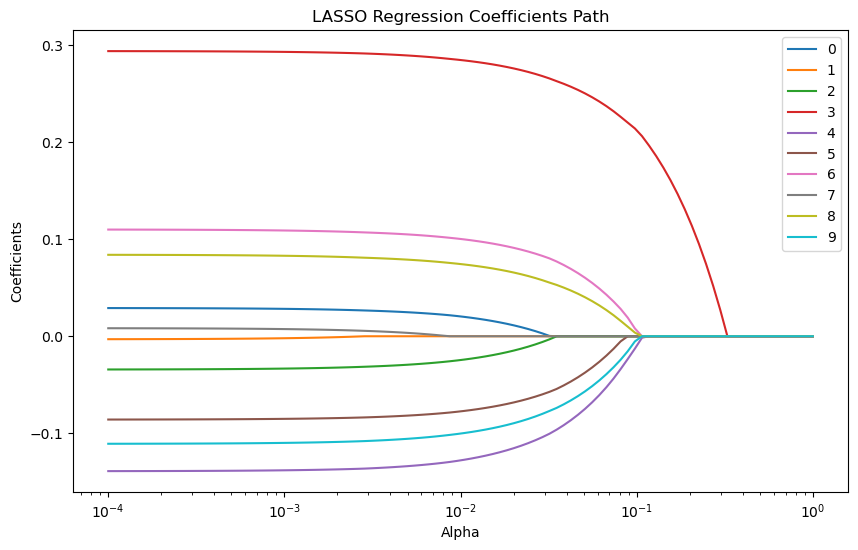

In [2]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# 生成样本数据
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)

# 初始化α值的范围
alphas = np.logspace(-4, 0, 100)

# 存储模型的系数
coefs = []

# 创建Lasso对象，并进行系数估计
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    coefs.append(model.coef_)

# 绘制α值与系数路径的图表
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('LASSO Regression Coefficients Path')
plt.axis('tight')
plt.legend(range(n_features))
plt.show()

可以看到，Lasso回归最终会趋于一条直线，原因就在于好多θ值已经均为0。LASSO回归使用L1范数作为惩罚项，具有稀疏性，即可以将某些系数压缩到零。这使得LASSO回归在**特征选择和变量筛选**方面非常有用。

### lasso回归参数选择

在Scikit-learn中，你可以使用LassoCV和LassoLarsCV来通过交叉验证来设置Lasso回归的alpha参数。

* LassoCV：基于交叉验证的Lasso回归方法。它可以自动选择最佳的 $\alpha$ 值，并进行模型拟合。LassoCV利用交叉验证来评估不同 $\alpha$ 值下的性能，并选择使得模型性能达到最优的alpha值。对于具有许多线性回归的高维数据集，常常使用LassoCV。

* LassoLarsCV：基于交叉验证的Lasso回归方法，并采用了最小角回归算法（LARS）来寻找最佳的alpha参数值。在样本数量比特征数量少得多的情况下，LassoLarsCV通常比LassoCV更快速且具有更好的性能。

下面是使用LassoCV和LassoLarsCV的示例代码：

In [6]:
from sklearn.linear_model import LassoCV, LassoLarsCV

# 使用LassoCV进行Lasso回归及alpha参数选择
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X, y)
best_alpha_lasso = lasso_cv.alpha_
print(best_alpha_lasso)

# 使用LassoLarsCV进行Lasso回归及alpha参数选择
lasso_lars_cv = LassoLarsCV(cv=5)
lasso_lars_cv.fit(X, y)
best_alpha_lassolars = lasso_lars_cv.alpha_
print(best_alpha_lassolars)


0.17465020215558855
0.1817744842195405


### 多任务lasso回归

多任务Lasso（Multi-Task Lasso）是一种用于多任务回归的正则化方法。它是对Lasso回归的扩展，可以同时处理多个相关联的目标变量。

在多任务Lasso中，目标函数的表达式如下：

$\underset{W}{\text{minimize }} \frac{1}{2n_{samples}} ||X W - Y||F ^ 2 + \alpha ||W||{21}$

其中，$X$ 是输入特征矩阵，$Y$ 是多个目标变量的观测值矩阵，**$W$** 是模型的系数矩阵，(\alpha) 是正则化参数。

* 第一项 $\frac{1}{2n_{samples}} ||X W - Y||F ^ 2$ 衡量了模型预测值与真实观测值之间的误差。这里使用了Frobenius范数来计算误差的平方和，同时将其除以 (2n{samples}) 进行归一化，其中 (n_{samples}) 是样本数量。

* 第二项 $\alpha ||W||_{21}$ 是指系数矩阵 $W$ 的 $L2,1$ 范数，也称为分组Lasso范数。$L2,1$ 范数将每个任务之间的系数向量视为一个分组，并对每个分组的L2范数进行惩罚。这鼓励模型选择相同或相似的特征子集来适应多个相关任务。

通过调整正则化参数 $\alpha$ 的大小，可以控制模型的拟合程度和稀疏性。

多任务Lasso适用于在多个相关任务上进行回归建模，并且鼓励共享特征选择。它可以通过联合优化多个相关任务来提高模型的性能，并且可以识别出对所有任务都有影响的重要特征。

在Scikit-learn中，可以使用MultiTaskLasso类来实现多任务Lasso回归，并进行参数估计和模型拟合。

In [7]:
from sklearn.linear_model import MultiTaskLasso
import numpy as np

# 生成样本数据
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
Y = np.random.randn(n_samples, 5)  # 生成5个相关联的目标变量

# 创建MultiTaskLasso对象并进行拟合
alpha = 0.1  # 正则化参数
multi_task_lasso = MultiTaskLasso(alpha=alpha)
multi_task_lasso.fit(X, Y)

# 输出模型系数
print("模型系数：")
print(multi_task_lasso.coef_)

模型系数：
[[ 0.02731864  0.08910204  0.03778079  0.00933277 -0.01963377 -0.00207699
   0.02826692  0.00827997 -0.12920136 -0.04683641]
 [-0.06873417 -0.0625006   0.02790663 -0.00367414  0.11322009  0.00652524
  -0.00146783 -0.05008547 -0.02371156  0.03941871]
 [-0.02352807 -0.08121243  0.06746598  0.02794926 -0.04672092 -0.03314402
   0.02533989 -0.03688576  0.08089949  0.032083  ]
 [ 0.029961   -0.03568944  0.07128624 -0.01492458  0.0525043   0.09876974
   0.10219089 -0.01597094 -0.02868559  0.05300582]
 [-0.03094184 -0.12592359 -0.17639916  0.00561484 -0.01498715 -0.06237257
  -0.00310203  0.01522918  0.07753082  0.02590595]]



## 岭回归


岭回归（Ridge Regression）是一种用于解决线性回归问题的正则化方法。岭回归通过引入一个正则化项，即岭惩罚项，来解决这个问题。岭回归的目标函数由两部分组成：一个是最小化拟合残差的平方和，另一个是控制参数向量的大小的惩罚项。

具体地，岭回归的目标函数可表示为：

$$\underset{w}{min} || Xw - y||_2^2 + \alpha ||w||_2^2$$

其中，$X$ 是输入数据矩阵，$y$ 是对应的观测值向量，$w$ 是待估计的参数向量，$\alpha$ 是一个控制正则化强度的超参数， $||w||_2 ^ 2$ 是L2范数的平方，也被称为岭项。

L2范数的正则化效果，在岭回归中表现出一个典型的"岭"形状，即在目标函数中形成一个凸形的曲线。这个曲线在系数空间中的形状类似于山脊或岭，因此得名为岭回归。

通过引入 $\alpha$ 的值，岭回归可以对参数向量进行限制，使其不会过大，从而减小过拟合的风险。较大的 $\alpha$ 值会增加正则化的程度，从而更加平衡模型的复杂度和拟合残差之间的权衡。

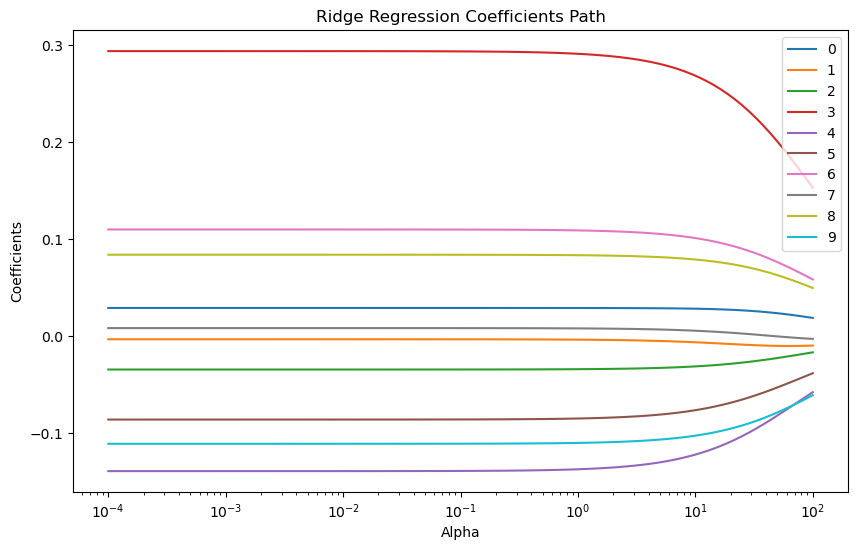

In [3]:
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# 生成样本数据
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)

# 初始化α值的范围
alphas = np.logspace(-4, 2, 100)

# 存储模型的系数
coefs = []

# 创建Ridge对象，并进行系数估计
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    coefs.append(model.coef_)

# 绘制α值与系数路径的图表
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Coefficients Path')
plt.axis('tight')
plt.legend(range(n_features))
plt.show()

从图中可以看出，岭回归的正则化参数变化对系数的影响是比较平滑的。另外不会变成0，所以计算量是比较大的。



### 岭回归参数选择
在Ridge回归中，可以使用广义交叉验证（Generalized Cross-Validation，GCV）来选择最优的正则化参数。Sklearn库中的RidgeCV类提供了自动进行岭回归和正则化参数选择的功能。

RidgeCV类使用方法类似于GridSearchCV，可以指定一组候选的 $\alpha$ 参数值。通过对这些参数值进行交叉验证，RidgeCV会选择具有最佳性能的 $\alpha$ 值，并将其作为Ridge模型的正则化参数。

以下是一个示例：

In [4]:
from sklearn import linear_model

# 定义一组候选的alpha参数值
alphas = [0.1, 1.0, 10.0]

# 创建RidgeCV对象并进行拟合
reg = linear_model.RidgeCV(alphas=alphas)
reg.fit([[0, 0], [0, 0], [1, 1]], [0, 0.1, 1])

# 输出选择的最优alpha值
print(reg.alpha_)

0.1


## 弹性网络

弹性网络（Elastic Net）是一种结合了L1范数和L2范数的线性回归正则化方法。它综合了Lasso回归和岭回归的优点，并旨在克服它们各自的限制。

弹性网络的目标函数表达式如下：

$$\underset{w}{\text{minimize }} \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 + \frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2$$

其中，$X$ 是输入特征矩阵，$w$ 是模型的系数向量，$y$ 是观测值向量，$\alpha$ 是正则化参数，$\rho$ 是混合比例参数。

* 第一项 $\frac{1}{2n_{samples}} ||X w - y||_2 ^ 2$ 衡量了模型预测值与真实观测值之间的误差。这里使用了L2范数来计算误差的平方和，同时将其除以 $2n_{samples}$ 进行归一化，其中 $n_{samples}$ 是样本数量。

* 第二项 $\alpha \rho ||w||_1$ 是L1范数的惩罚项，用于促使模型的系数稀疏化，即让部分系数趋向于零。

* 第三项 $\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2$ 是L2范数的惩罚项，用于控制模型的复杂度并避免过拟合。

通过调整正则化参数 $\alpha$ 和混合比例参数 $\rho$ 的大小，可以控制模型的拟合程度、稀疏性和复杂度。

弹性网络适用于在存在多个相关特征和噪声的情况下进行回归建模。它可以同时进行特征选择和模型拟合，并具有较好的泛化能力。

在Scikit-learn中，可以使用ElasticNet类来实现弹性网络回归，并进行参数估计和模型拟合。

In [8]:
from sklearn.linear_model import ElasticNet
import numpy as np

# 生成样本数据
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)

# 创建ElasticNet对象并进行拟合
alpha = 0.1  # 正则化参数
l1_ratio = 0.5  # 混合比例参数
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic_net.fit(X, y)

# 输出模型系数
print("模型系数：")
print(elastic_net.coef_)

模型系数：
[ 0.         -0.         -0.          0.23961679 -0.07092795 -0.03552143
  0.05895168  0.          0.03982252 -0.05629927]
